In [1]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df2 = df[["LR_DATE","Net_Total"]]
df2.head(5)

,LR_DATE,Net_Total
0,2019-01-01,39100
1,2019-01-01,9100
2,2019-01-01,2604
3,2019-01-01,1171
4,2019-01-01,4756


In [4]:
df2 = df2.groupby(["LR_DATE"])['Net_Total'].sum().reset_index()
print(df2.head(),"\n"*2,df2.count())

     LR_DATE  Net_Total
0 2019-01-01     127828
1 2019-01-02     224970
2 2019-01-03     225695
3 2019-01-04     229894
4 2019-01-05     231303 

 LR_DATE      354
Net_Total    354
dtype: int64


In [5]:
df2["LR_DATE"]= pd.to_datetime(df2['LR_DATE'], infer_datetime_format = True)

In [10]:
 indexed_df= df2.set_index(['LR_DATE'])

In [11]:
indexed_df.head()

,Net_Total
LR_DATE,
2019-01-01,127828
2019-01-02,224970
2019-01-03,225695
2019-01-04,229894
2019-01-05,231303


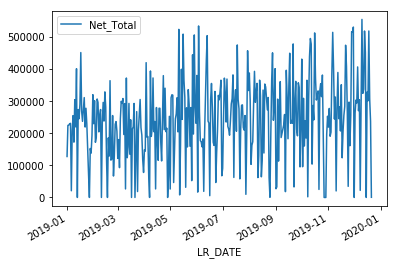

In [12]:
indexed_df.plot()

In [86]:
from statsmodels.tsa.stattools import adfuller

#running tests to check if stationary
def test_stationary(timeseries):
    
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=120).mean()
    movingSTD = timeseries.rolling(window=120).std()
    
    #Plot Rolling statistics
    orig= plt.plot(timeseries, color="blue", label='original')
    mean= plt.plot(movingAverage, color='red', label='Rolling mean')
    std= plt.plot(movingSTD,color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling mean and standard deviation')
    plt.show(block= False)
    
    #Perform Dickey Fuller Test
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Net_Total'],autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', '#Lags Used', 'Numbers of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key]=value
        
    print(dfoutput)

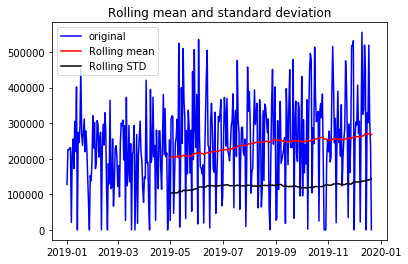

Results of Dickey Fuller Test:
Test Statistic                   -3.252230
p-value                           0.017154
#Lags Used                       13.000000
Numbers of Observations Used    340.000000
Critical Value(1%)               -3.449730
Critical Value(5%)               -2.870079
Critical Value(10%)              -2.571319
dtype: float64


In [87]:
test_stationary(indexed_df)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


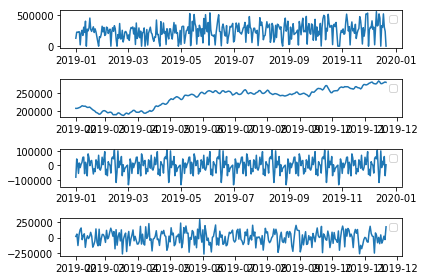

In [232]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexed_df, freq=60)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexed_df, Label="Original")
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, Label="trend")
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, Label="seasonal")
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, Label="residual")
plt.legend(loc='best')

plt.tight_layout()


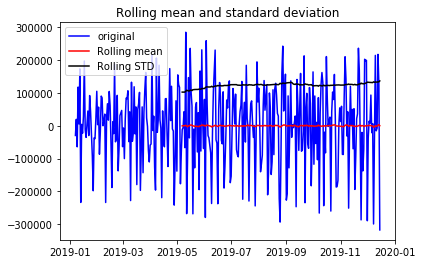

Results of Dickey Fuller Test:
Test Statistic                 -9.018926e+00
p-value                         5.846845e-15
#Lags Used                      1.700000e+01
Numbers of Observations Used    3.240000e+02
Critical Value(1%)             -3.450695e+00
Critical Value(5%)             -2.870502e+00
Critical Value(10%)            -2.571545e+00
dtype: float64


In [176]:
decomposed = residual
decomposed.dropna(inplace =True)

test_stationary(decomposed)

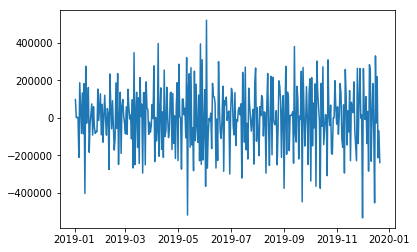

In [177]:
data_shifted_diff = indexed_df-indexed_df.shift(periods=1)
plt.plot(data_shifted_diff)

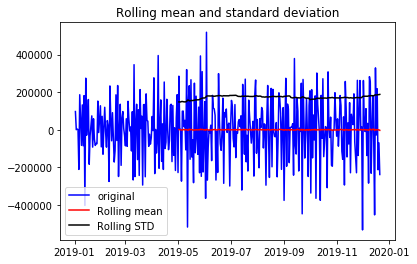

Results of Dickey Fuller Test:
Test Statistic                 -1.057965e+01
p-value                         6.958663e-19
#Lags Used                      1.200000e+01
Numbers of Observations Used    3.400000e+02
Critical Value(1%)             -3.449730e+00
Critical Value(5%)             -2.870079e+00
Critical Value(10%)            -2.571319e+00
dtype: float64


In [178]:
data_shifted_diff.dropna(inplace=True)
test_stationary(data_shifted_diff)

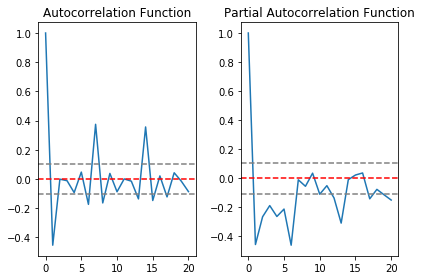

In [179]:
#ACF and PACF graphs
from statsmodels.tsa.stattools import acf,pacf

lag_acf= acf(data_shifted_diff, nlags= 20)
lag_pacf= pacf(data_shifted_diff, nlags=20, method='ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(data_shifted_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_shifted_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(data_shifted_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_shifted_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting AR model


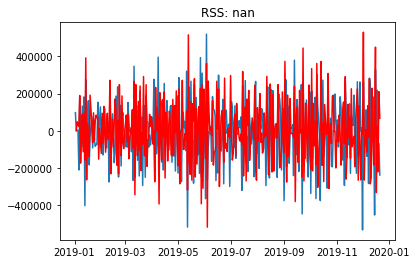

In [220]:
from statsmodels.tsa.arima_model import ARIMA

#AR model
model= ARIMA(indexed_df, order=(0,2,1))
results_AR= model.fit(disp=-1)
plt.plot(data_shifted_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-data_shifted_diff["Net_Total"])**2))
print('Plotting AR model')


In [221]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

LR_DATE
2019-01-03       -16.980456
2019-01-04     48183.029292
2019-01-05     29789.039047
2019-01-06     24417.298800
2019-01-07    188955.258297
dtype: float64


In [222]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

LR_DATE
2019-01-03       -16.980456
2019-01-04     48166.048836
2019-01-05     77955.087882
2019-01-06    102372.386683
2019-01-07    291327.644980
dtype: float64


In [223]:
predictions_ARIMA = pd.Series(indexed_df['Net_Total'].ix[0], index= indexed_df.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


LR_DATE
2019-01-01    127828.000000
2019-01-02    127828.000000
2019-01-03    127811.019544
2019-01-04    175994.048836
2019-01-05    205783.087882
dtype: float64

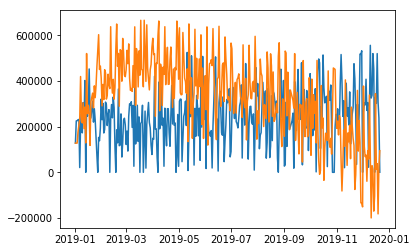

In [224]:
plt.plot(indexed_df)
plt.plot(predictions_ARIMA)